# Detecting discoveries
Natalia Vélez, July 2020

In [1]:
%matplotlib inline

import os, re, glob
import pandas as pd
import numpy as np
from os.path import join as opj

import scipy.stats
from gini import gini
from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import notebook

sns.set_style("white")
sns.set_context("talk")

## Prepare data

Helper: Extract timestamp from filenames

In [2]:
def file_start(f):
    t0 = re.search('((?<=start-)|(?<=time-))[0-9]+', f).group(0)
    return int(t0)

Family labels:

In [3]:
fam_file = '../2_demographics/outputs/family_playerID.tsv'
fam_df = pd.read_csv(fam_file, sep='\t', index_col=0)
fam_df = fam_df.rename(columns={'playerID':'player_id'})
fam_df['fam_start'] = fam_df['family'].apply(file_start)
fam_df.head()

/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,player_id,family,fam_start
0,3080084,time-1592284232_eve-3080067_name-PICKLE,1592284232
1,3080114,time-1592284232_eve-3080067_name-PICKLE,1592284232
2,3080111,time-1592284232_eve-3080067_name-PICKLE,1592284232
3,3080108,time-1592284232_eve-3080067_name-PICKLE,1592284232
4,3080104,time-1592284232_eve-3080067_name-PICKLE,1592284232


Family fitness:

In [4]:
fit_file = '../2_demographics/outputs/family_fitness.tsv'
fit_df = pd.read_csv(fit_file, sep='\t', index_col=None)
print('Analyzing %i families' % fit_df.shape[0])
fit_df.head()

Analyzing 3084 families


,family,sum,count,a,b,beta_mean,beta_var,snr,weighted_size
0,time-1573261529_eve-2252167_name-VIERNES,1,2,4,4,0.500000,0.027778,18.000000,1.000000
1,time-1573261796_eve-2252178_name-BELAND,2,8,5,9,0.357143,0.015306,23.333333,2.857143
2,time-1573261810_eve-2252180_name-BRAND,4,11,7,10,0.411765,0.013456,30.600000,4.529412
3,time-1573261816_eve-2252182_name-GERMAN,4,12,7,11,0.388889,0.012508,31.090909,4.666667
4,time-1573261826_eve-2252186_name-LOLI,4,16,7,15,0.318182,0.009432,33.733333,5.090909


Object depth:

In [5]:
depth_file = '../../tech_tree/transition.csv'
depth_df = pd.read_csv(depth_file)
depth_df = depth_df.rename(columns={'id': 'object_id', 'num_ingredients': 'depth'})
depth_df = depth_df[['object_id', 'depth']]
depth_df.head()

,object_id,depth
0,11,0
1,19,0
2,30,0
3,31,1
4,32,0


Find map change files:

In [6]:
gsearch = lambda *args: glob.glob(opj(*args))
map_dir = 'outputs/maplog/'

map_files = gsearch(map_dir, '*.tsv')
map_files.sort()

print('Found %i files' % len(map_files))
print(*map_files[:10], sep='\n')

Found 236 files
outputs/maplog/maplog_release-284_start-1573895672.tsv
outputs/maplog/maplog_release-284_start-1573982073.tsv
outputs/maplog/maplog_release-284_start-1574068473.tsv
outputs/maplog/maplog_release-285_start-1574102503.tsv
outputs/maplog/maplog_release-287_start-1574151678.tsv
outputs/maplog/maplog_release-287_start-1574238079.tsv
outputs/maplog/maplog_release-287_start-1574324479.tsv
outputs/maplog/maplog_release-287_start-1574410879.tsv
outputs/maplog/maplog_release-287_start-1574497279.tsv
outputs/maplog/maplog_release-289_start-1574552311.tsv


Find map seed changes:

In [7]:
seed_file = 'outputs/seed_changes.txt'
with open(seed_file, 'r') as handle:
    seed_data = handle.read().splitlines()

seed_changes = np.array([int(s) for s in seed_data])
seed_changes = np.sort(seed_changes)

print(seed_changes)

[1573895673 1574102503 1576038671 1578345720 1578354747 1579713519
 1580144896 1581985139 1583642903 1584061484 1585440511 1585512770
 1585603481 1587166656]


Find seed file corresponding to timestamp:

In [8]:
def find_seed(tstamp):
    
    lag = tstamp - seed_changes
    seeds = seed_changes[lag >= 0]
    if len(seeds):
        seed = seeds[-1]
    else: # Special: First log file
        seed = seed_changes[0]
            
    return seed

Group mapchange files by world seed:

In [9]:
file_df = pd.DataFrame(map_files, columns=['file'])
file_df['tstamp'] = file_df.file.str.extract('(?<=start-)([0-9]+)')
file_df['tstamp'] = file_df['tstamp'].astype(np.int)
file_df['seed'] = file_df.tstamp.apply(find_seed)
file_df = file_df.sort_values('tstamp')
file_df['seed_start'] = file_df.groupby('seed')['tstamp'].transform('min')

file_df.head()

,file,tstamp,seed,seed_start
0,outputs/maplog/maplog_release-284_start-157389...,1573895672,1573895673,1573895672
1,outputs/maplog/maplog_release-284_start-157398...,1573982073,1573895673,1573895672
2,outputs/maplog/maplog_release-284_start-157406...,1574068473,1573895673,1573895672
3,outputs/maplog/maplog_release-285_start-157410...,1574102503,1574102503,1574102503
4,outputs/maplog/maplog_release-287_start-157415...,1574151678,1574102503,1574102503


## Identify discoveries

Helper function: Clean up individual map change files

In [10]:
def process_maplog(f):
    s_df = pd.read_csv(f, sep='\t', index_col=None)
    
    # Fix timestamps to start of world seed
    t_log = file_start(f)
    s_df['t_epoch'] = s_df['t_elapsed'] + t_log

    # Player events only
    s_df = s_df[s_df['player_id'] > 0]

    # Parse object IDs, removing special identifiers
    s_df['object_id'] = s_df.object_id.str.replace('(^f|v[0-9]+|u[0-9]+)', '')
    s_df['object_id'] = s_df['object_id'].astype(np.int)

    # Only interactions with valid objects
    s_df = s_df[(s_df['object_id'] > 0) & (s_df['object_id'] < 5000)]

    # Tag players by family
    s_df = pd.merge(s_df, fam_df, on='player_id')
    s_df['t_fam'] = s_df['t_epoch'] - s_df['fam_start'] # t=0 at Eve birth

    return s_df

Identify discoveries

In [11]:
def id_discoveries(maplog):

    # Prepare dataframe
    discoveries = maplog.copy()
    discoveries = discoveries[['seed','t_fam','family', 'object_id', 'x', 'y', 'player_id']]
    discoveries = discoveries.sort_values('t_fam')

    # Find the first time an object appears in family's repertoire
    discoveries = discoveries.groupby(['seed', 'family', 'object_id']).first()
    discoveries = discoveries.reset_index()
    discoveries = pd.merge(discoveries, depth_df)
    discoveries = discoveries.sort_values(['family', 't_fam'])

    return discoveries

Count # of discoveries per player:

In [12]:
def count_discoveries(discoveries):
    # Return a count of # discoveries for each family member
    n_discoveries = discoveries.groupby(['family','player_id'])['object_id']
    n_discoveries = n_discoveries.agg('count').reset_index()
    n_discoveries = n_discoveries.rename(columns={'object_id': 'n'})

    # Fill in missing family members (no discoveries)
    log_fams = np.unique(discoveries['family'])
    all_fam = fam_df.copy()
    all_fam = all_fam[['family', 'player_id']]
    all_fam = all_fam[all_fam['family'].isin(log_fams)].reset_index(drop=True)

    # Total number of discoveries
    n_discoveries_full = pd.merge(all_fam, n_discoveries, how='outer')
    n_discoveries_full['n'] = n_discoveries_full['n'].fillna(0).astype(int)
    
    # Family totals
    fam_totals = n_discoveries_full.groupby('family')['n'].agg(['sum', 'count']).reset_index()
    n_discoveries_full = pd.merge(n_discoveries_full, fam_totals, on='family', how='outer')
    n_discoveries_full = n_discoveries_full.sort_values(['family', 'n'], ascending=True)
    
    # Cumulative players and discoveries
    n_discoveries_full['cum_players'] = n_discoveries_full.groupby('family')['n'].cumcount()+1
    n_discoveries_full['cum_players'] = n_discoveries_full['cum_players']/n_discoveries_full['count']
    
    n_discoveries_full['cum_discoveries'] = n_discoveries_full.groupby('family')['n'].cumsum()
    n_discoveries_full['cum_discoveries'] = n_discoveries_full['cum_discoveries']/n_discoveries_full['sum']
    
    return n_discoveries_full

Plot Lorenz curves (used to visualize innovation inequality):

In [13]:
# Plot Lorenz curve
def plot_lorenz(in_df, name, seed):
    highlight_col = '#ffad3b'
    fig, ax = plt.subplots(figsize=(6,6))
    
    # Insert point at origin 
    origin = pd.DataFrame({'family': [name],
                           'playerID': [0],
                           'n': [0],
                           'sum': [0],
                           'count': [0],
                           'cum_players': [0],
                           'cum_discoveries': [0]})
    
    df = pd.concat([origin, in_df])
    # Cumulative distribution
    sns.lineplot(data = df, x = 'cum_players', y = 'cum_discoveries', color = highlight_col, ax=ax)

    # Fill in area over Lorenz curve
    ax.fill_between(df['cum_players'], df['cum_discoveries'], df['cum_players'],
                   color = highlight_col)

    # Write Gini coefficient on plot
    g = gini(df['cum_discoveries'].values)
    ax.text(0.75, 0.05, 'G = %.2f' % g, 
            bbox = {'facecolor': '#ffffff', 'edgecolor': highlight_col})

    # Line of equality
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='-', color='black', linewidth = 1) 

    ## Customize
    ax.yaxis.tick_right() # Move axes to the right
    ax.tick_params(axis = "y", which = "both", right = False)

    ax.yaxis.set_label_position("right")
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.set(xlim = [0,1], ylim= [0,1], aspect = 1.0,
           xlabel='Cumulative share of characters\n(Fewest to most discoveries)',
           ylabel='Cumulative share of discoveries')

    #  Save to file
    plot_file = 'plots/discoveries/seed-%i_%s_lorenz.png' % (seed, name)
    plt.savefig(plot_file, bbox_inches = 'tight')
    plt.close()
        
    return g

Plot distribution of #n discoveries (useful to interpret Lorenz curve):

In [14]:
def plot_dist(df, name, seed):
    ax = sns.distplot(df['n'], kde=False)
    ax.set(xlabel='# discoveries')
    sns.despine()
    
    plot_file = 'plots/discoveries/seed-%i_%s_dist.png' % (seed, name)
    plt.savefig(plot_file, bbox_inches = 'tight')
    plt.close()

Main loop:

In [16]:
rep_list = []
gini_list = []

for s in notebook.tqdm(seed_changes):

    # Identify all logs with the same world seed
    seed_logs = file_df[file_df['seed'] == s].copy()
    seed_fs = seed_logs['file'].values
    
    if len(seed_fs):

        # Add all logs associated with the same world seed to dataframe
        seed_list = [process_maplog(f) for f in seed_fs]
        seed_df = pd.concat(seed_list).reset_index(drop=True)
        seed_df['seed'] = s

        # Identify discoveries by family
        # = first time a family member interacts with an object, by world seed
        seed_disc = id_discoveries(seed_df)
        seed_n_disc = count_discoveries(seed_disc)
        seed_n_disc['seed'] = s

        # Depth and breadth of repertoire
        seed_repertoire = seed_disc.groupby('family').agg({'object_id': 'count', 'depth': 'max'}).reset_index()
        seed_repertoire = seed_repertoire.rename(columns={'object_id': 'breadth'})

        # Innovation inequality
        for name,group in notebook.tqdm(seed_n_disc.groupby('family')):    

            g = plot_lorenz(group, name, s)
            plot_dist(group, name, s)
            gini_list.append((s, name, g))

        # Add to lists
        rep_list.append(seed_repertoire)

Concat dataframes:

In [35]:
rep_df = pd.concat(rep_list)
rep_df['log_breadth'] = np.log10(rep_df['breadth'])
rep_df['log_depth'] = np.log10(rep_df['depth'])
rep_df.to_csv('outputs/family_repertoire.tsv', sep='\t', index=False)
rep_df.head()

,family,breadth,depth,log_breadth,log_depth
0,time-1573895755_eve-2276905_name-ZABICKI,312,1164,2.494155,3.065953
1,time-1573895904_eve-2276911_name-ROHRER,45,28,1.653213,1.447158
2,time-1573896101_eve-2276917_name-BADA,350,659,2.544068,2.818885
3,time-1573896134_eve-2276919_name-SARINA,477,1164,2.678518,3.065953
4,time-1573896495_eve-2276927_name-LISSADE,1033,1164,3.014100,3.065953


In [47]:
gini_df = pd.DataFrame(gini_list, columns = ['seed', 'family', 'gini'])
gini_df.to_csv('outputs/family_gini.tsv', sep='\t', index=False)
gini_df.head()

,seed,family,gini
0,1573895673,time-1573895755_eve-2276905_name-ZABICKI,0.732728
1,1573895673,time-1573895904_eve-2276911_name-ROHRER,0.506757
2,1573895673,time-1573896101_eve-2276917_name-BADA,0.775139
3,1573895673,time-1573896134_eve-2276919_name-SARINA,0.714194
4,1573895673,time-1573896495_eve-2276927_name-LISSADE,0.796686


Plot innovation inequality:

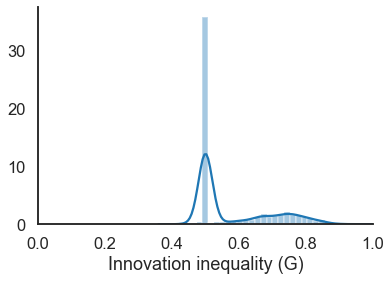

In [53]:
ax = sns.distplot(gini_df['gini'])
ax.set(xlabel='Innovation inequality (G)', xlim=(0,1))
sns.despine()

Relationship between G and community size:

In [57]:
size_df = pd.read_csv('../2_demographics/outputs/family_fitness.tsv', sep='\t', index_col=None)
size_df = size_df[['family', 'sum']]
size_df.head()

,family,sum
0,time-1573261529_eve-2252167_name-VIERNES,1
1,time-1573261796_eve-2252178_name-BELAND,2
2,time-1573261810_eve-2252180_name-BRAND,4
3,time-1573261816_eve-2252182_name-GERMAN,4
4,time-1573261826_eve-2252186_name-LOLI,4


In [63]:
g_size = pd.merge(gini_df, size_df, on='family', how='outer')
g_size['log_sum'] = np.log10(g_size['sum'])
g_size.head()

,seed,family,gini,sum,log_sum
0,1.573896e+09,time-1573895755_eve-2276905_name-ZABICKI,0.732728,9.0,0.954243
1,1.573896e+09,time-1573895904_eve-2276911_name-ROHRER,0.506757,1.0,0.000000
2,1.573896e+09,time-1573896101_eve-2276917_name-BADA,0.775139,14.0,1.146128
3,1.573896e+09,time-1573896134_eve-2276919_name-SARINA,0.714194,33.0,1.518514
4,1.573896e+09,time-1573896495_eve-2276927_name-LISSADE,0.796686,250.0,2.397940


array([0, 1, 2, 3, 4])

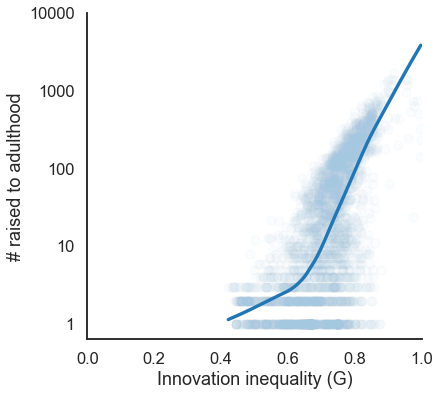

In [119]:
fig = plt.figure(figsize=(6,6))
ax = sns.regplot(x='gini', y='log_sum', data=g_size, 
                 scatter_kws={'alpha': 0.05, 'color': '#A5C8E1'}, 
                 line_kws = {'color': '#2276B4'},
                 lowess=True)
yticks =  np.arange(0,5)
ax.set_yticks(yticks)
yticklabels = [10**y for y in yticks]
ax.set(xlabel = 'Innovation inequality (G)',
       xlim = (0,1),
       ylabel = '# raised to adulthood',
       yticklabels=yticklabels)
sns.despine()

[(-0.1810722464679781, 3.598325967563699),
 Text(14.625, 0.5, 'log$_{10}$(depth)'),
 (-0.1810722464679781, 3.598325967563699),
 Text(0.5, 22.49999999999995, 'log$_{10}$(breadth)')]

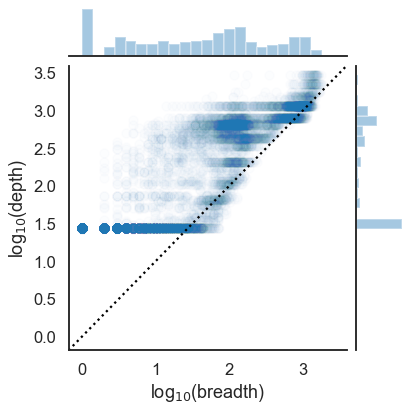

In [102]:
g = sns.jointplot(x='log_breadth',y='log_depth',data=rep_df, alpha=0.01)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')
g.ax_joint.set(xlabel = 'log$_{10}$(breadth)', ylabel = 'log$_{10}$(depth)',
               xlim = lims, ylim = lims)